In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time
from pathlib import Path
from glob import glob
from datetime import datetime
import spacy

nlp = spacy.load("en_core_web_sm")


In [2]:
if Path("./data/df_quotes.pickle").is_file():
    df_quotes = pd.read_pickle("./data/df_quotes.pickle")
else:
    df_quotes = pd.read_json(
        "data/natural_disaster_quotes.json.bz2", lines=True, compression="bz2"
    )
    df_quotes.to_pickle("./data/df_quotes.pickle")

print(f"Number of quotes: %d" % len(df_quotes.index))


Number of quotes: 1480711


In [3]:
# Turn the parquets into exploded pickles
files = sorted(glob("data/speaker_attributes.parquet/part*"))
for (i, f) in enumerate(files):
    if Path("data/speaker_chunks/chunk_" + str(i) + ".pickle").is_file():
        continue
    else:
        chunk = pd.read_parquet(f, engine="pyarrow").explode("aliases")
        chunk = chunk[chunk.aliases.isin(df_quotes.speaker)]
        chunk.to_pickle("data/speaker_chunks/chunk_" + str(i) + ".pickle")


In [4]:
# Regroup the chunks into one
files = sorted(glob("data/speaker_chunks/chunk*"))
chunks = pd.DataFrame()

for f in files:
    chunk = pd.read_pickle(f)
    chunks = chunks.append(chunk)

chunks.head(2)


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
3,President George W. Bush,[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
3,George Bush,[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"


In [5]:
# Load the Wikidata nodes
df_labels = pd.read_csv(
    "data/wikidata_labels_descriptions_quotebank.csv.bz2",
    compression="bz2",
    index_col="QID",
)
df_labels.head()


,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America


In [6]:
# Turn the wikinodes into human readable labels
cols = [
    "nationality",
    "occupation",
    "party",
    "academic_degree",
    "candidacy",
    "religion",
]
for col in cols:
    print(col)
    chunks[col] = chunks[col].apply(
        lambda l: [df_labels.loc[q]["Label"] for q in l] if l is not None else l
    )

chunks.head(2)
speakers = chunks


nationality
occupation
party
academic_degree
candidacy
religion


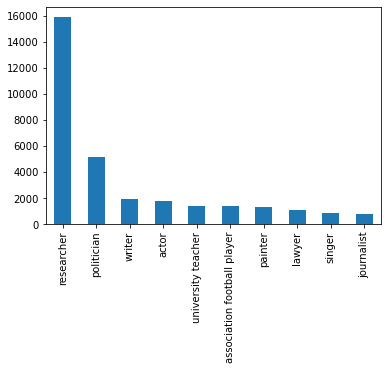

In [7]:
# Now to the fun stuff...

# Count and display the profession of the speakers
speakers.occupation.explode().value_counts().head(10).plot(kind="bar")


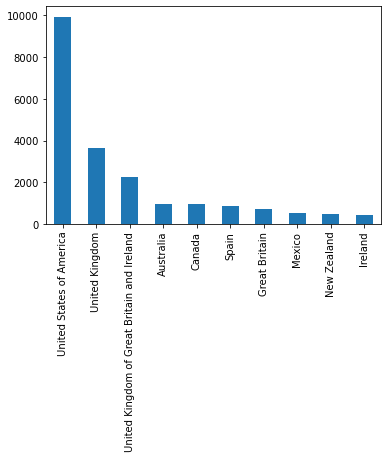

In [8]:
# Count and display Political party
speakers.nationality.explode().value_counts().head(10).plot(kind="bar")


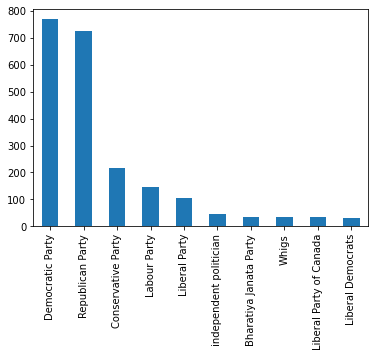

In [9]:
# Count and display Political party
chunks.party.explode().value_counts().head(10).plot(kind="bar")


In [14]:
# We will need to do matching later.....
# Do topic detection on the democrats and the republicans

## Get left wingers TODO include more parties than dems
democrats = speakers[
    speakers.party.apply(lambda l: "Democratic Party" in l if l is not None else False)
]

## Get right wingers TODO include more parties than repubs
republicans = speakers[
    speakers.party.apply(lambda l: "Republican Party" in l if l is not None else False)
]

## Get lefties quotes
left_quotes = df_quotes[df_quotes.speaker.isin(democrats.aliases)]
left_book = left_quotes.quotation.str.cat(sep="\n")
with open("data/left_book.txt", "w") as f:
    f.write(left_book)

## Get righties quotes
right_quotes = df_quotes[df_quotes.speaker.isin(republicans.aliases)]
right_book = right_quotes.quotation.str.cat(sep="\n")
with open("data/right_book.txt", "w") as f:
    f.write(right_book)


In [52]:
def get_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i : i + n]


# Get the quotes into chunks
from nltk.corpus import PlaintextCorpusReader

books = PlaintextCorpusReader("data", ".*book.txt")
print(books.fileids())
limit = 600
size = 50

chunks = list()
chunk_class = list()
book_id = {f: n for n, f in enumerate(books.fileids())}  # dictionary of books

for f in books.fileids():
    sentences = books.sents(f)
    print(f, ":")
    print("Num of sentences:", len(sentences))

    chunks_of_sents = [x for x in get_chunks(sentences, size)]
    chs = list()

    for c in chunks_of_sents:
        grouped_chunk = list()
        for sent in c:
            grouped_chunk.extend(sent)
        chs.append(" ".join(grouped_chunk))
    print("Num of chunks:", len(chs), "\n")

    # filter to the limit, to have the same number of chunks per book
    chunks.extend(chs[:limit])
    chunk_class.extend([book_id[f] for _ in range(len(chs[:limit]))])


['left_book.txt', 'right_book.txt']
left_book.txt :
Num of sentences: 35295
Num of chunks: 706 

right_book.txt :
Num of sentences: 32330
Num of chunks: 647 



In [53]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(chunks)

print("Number of samples:", X.toarray().shape[0])
print("Number of features:", X.toarray().shape[1])

Y = chunk_class

X, Y = shuffle(X, Y, random_state=0)

# split into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)


Number of samples: 1200
Number of features: 25608


In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

accs = []

scaler = preprocessing.StandardScaler(with_mean=False)

# X_scaled = scaler.fit(X_train).transform(X_train)

# the grid of regularization parameter
grid = [0.01, 0.1, 1, 10, 100, 1000, 10000]

for c in grid:

    # initialize the classifier
    # Increase max iter by a lot because scaling gave worst results, but this
    # causes it to take a lot of time to compute.... TODO take logs of X to
    # scale it instead of normalizing and see if that keeps the good results
    clf = LogisticRegression(random_state=0, C=c, max_iter=1000) 

    # crossvalidate
    scores = cross_val_score(clf, X_train, Y_train, cv=10)
    accs.append(np.mean(scores))


/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0.70625, 0.6989583333333333, 0.6916666666666668, 0.6916666666666667, 0.6937499999999999, 0.6937499999999999, 0.7020833333333334]


Text(0, 0.5, 'Crossvalidation accuracy')

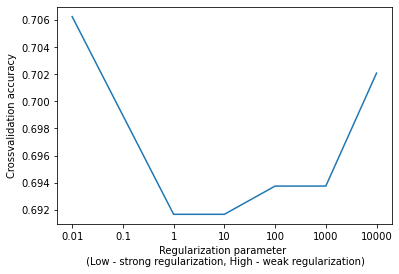

In [55]:
print(accs)
plt.plot(accs)
plt.xticks(range(len(grid)), grid)
plt.xlabel('Regularization parameter \n (Low - strong regularization, High - weak regularization)')
plt.ylabel('Crossvalidation accuracy')


In [58]:
clf = LogisticRegression(random_state=0, C = 0.01, max_iter=1000).fit(X_train, Y_train)

#predict on the test set
print('Accuracy:',clf.score(X_test,Y_test))

Accuracy: 0.7375


In [70]:
coefs=clf.coef_[0]
top_three = np.argpartition(coefs, -20)[-20:]

print(np.array(vectorizer.get_feature_names_out())[top_three])

['terrorism' 'panhandle' 'tornado' 'certainly' 'threatening' 'be'
 'liberal' 'irma' 'snow' 'probably' 'nuclear' 'hurricane' 'could'
 'florida' 'floridians' 'storm' 'surge' 'prepared' 'think' 'biological']


array(['global', 'taken', 'new', ..., '075', '01', '00'], dtype=object)